In [42]:
import random
from PIL import Image, ImageDraw

# Load the provided background image
background_image_path = './network.webp'
background_image = Image.open(background_image_path)

# Update the drawing functions to use the specified colors
class Star:
    def __init__(self, radius, color, position):
        self.radius = radius
        self.color = color
        self.position = position

    def draw(self, image):
        draw = ImageDraw.Draw(image)
        left_up_point = (self.position[0] - self.radius, self.position[1] - self.radius)
        right_down_point = (self.position[0] + self.radius, self.position[1] + self.radius)
        draw.ellipse([left_up_point, right_down_point], fill=self.color + (255,))

    @classmethod
    def from_dict(cls, data):
        return cls(
            radius=data.get('radius', random.randint(5, 10)),
            color=data.get('color', (0, 0, 255)),  # Blue stars
            position=data.get('position', (random.randint(0, 1200), random.randint(0, 1200)))
        )


class Corona:
    def __init__(self, star_radius, outer_radius, color, position):
        self.inner_radius = star_radius
        self.outer_radius = outer_radius
        self.color = color
        self.position = position

    def draw(self, image):
        draw = ImageDraw.Draw(image)
        for i in range(self.inner_radius, self.outer_radius):
            alpha = int(255 * (1 - (i - self.inner_radius) / (self.outer_radius - self.inner_radius)) ** 2)
            left_up_point = (self.position[0] - i, self.position[1] - i)
            right_down_point = (self.position[0] + i, self.position[1] + i)
            draw.ellipse([left_up_point, right_down_point], outline=self.color + (alpha,), width=1)

    @classmethod
    def from_dict(cls, data):
        return cls(
            star_radius=data['star_radius'],
            outer_radius=data.get('outer_radius', data['star_radius'] + random.randint(1, 10)),
            color=data.get('color', (255, 0, 0)),  # Red coronas
            position=data['position']
        )


class StarSpike:
    def __init__(self, length, width, color, position, orientation):
        self.length = length
        self.width = width
        self.color = color
        self.position = position
        self.orientation = orientation

    def draw(self, image):
        draw = ImageDraw.Draw(image)
        if self.orientation == 'horizontal':
            left_up_point = (self.position[0] - self.length, self.position[1] - self.width // 2)
            right_down_point = (self.position[0] + self.length, self.position[1] + self.width // 2)
        else:
            left_up_point = (self.position[0] - self.width // 2, self.position[1] - self.length)
            right_down_point = (self.position[0] + self.width // 2, self.position[1] + self.length)
        draw.ellipse([left_up_point, right_down_point], fill=self.color + (255,))

    @classmethod
    def from_dict(cls, data):
        return cls(
            length=data['length'],
            width=data['width'],
            color=data.get('color', (0, 255, 0)),  # Green rays
            position=data['position'],
            orientation=data['orientation']
        )


class StarSpikeCorona:
    def __init__(self, inner_length, outer_length, width, color, position, orientation):
        self.inner_length = inner_length
        self.outer_length = outer_length
        self.width = width
        self.color = color
        self.position = position
        self.orientation = orientation

    def draw(self, image):
        draw = ImageDraw.Draw(image)
        for i in range(self.inner_length, self.outer_length):
            alpha = int(255 * (1 - (i - self.inner_length) / (self.outer_length - self.inner_length)) ** 2)
            if self.orientation == 'horizontal':
                left_up_point = (self.position[0] - i, self.position[1] - self.width // 2)
                right_down_point = (self.position[0] + i, self.position[1] + self.width // 2)
            else:
                left_up_point = (self.position[0] - self.width // 2, self.position[1] - i)
                right_down_point = (self.position[0] + self.width // 2, self.position[1] + i)
            draw.ellipse([left_up_point, right_down_point], outline=self.color + (alpha,), width=1)

    @classmethod
    def from_dict(cls, data):
        return cls(
            inner_length=data['inner_length'],
            outer_length=data['outer_length'],
            width=data['width'],
            color=data.get('color', (255, 255, 0)),  # Yellow ray coronas
            position=data['position'],
            orientation=data['orientation']
        )


class StarrySkyAnimationWithVariedRaysAndTiming:
    min_radius = 5
    max_radius = 10
    min_outer_radius_offset = 1
    max_outer_radius_offset = 10
    min_twinkle_interval = 10
    max_twinkle_interval = 30
    min_spike_length = 5
    max_spike_length = 10
    spike_width = 3

    def __init__(self, size=(1200, 1200), background_color=(0, 0, 0), star_count=20, frame_count=60, star_positions=None):
        if background_image_path:
            self.background_image = Image.open(background_image_path)
            if size == (1200, 1200):  # Default size, adjust to image size if not explicitly specified
                self.size = self.background_image.size
            else:
                self.size = size
                self.background_image = self.background_image.resize(self.size)
        else:
            self.size = size
            self.background_image = Image.new("RGB", self.size, background_color)
        self.background_color = background_color
        self.star_count = star_count
        self.frame_count = frame_count
        self.image_sequence = []
        self.stars = [
            Star.from_dict({
                'radius': random.randint(self.min_radius, self.max_radius),
                'position': position
            }) for position in (star_positions or [(random.randint(0, size[0]), random.randint(0, size[1])) for _ in range(star_count)])
        ]
        self.coronas = [
            Corona.from_dict({
                'star_radius': star.radius,
                'position': star.position
            }) for star in self.stars
        ]
        self.twinkle_intervals = [random.randint(self.min_twinkle_interval, self.max_twinkle_interval) for _ in range(self.star_count)]

    def get_adjusted_length(self, spike_length, frame):
        if frame % 5 == 0 or frame % 5 == 4:
            return int(spike_length * 1/3)
        elif frame % 5 == 1 or frame % 5 == 3:
            return int(spike_length * 2/3)
        else:
            return int(spike_length)

    def create_spikes(self, image, star, spike_length, num_rays, frame):
        orientations = ['horizontal', 'vertical']
        colors = [(0, 255, 0), (0, 255, 0)]
        
        adjusted_length = self.get_adjusted_length(spike_length, frame)
        
        for _ in range(num_rays // 2):
            for orientation, color in zip(orientations, colors):
                spike = StarSpike.from_dict({
                    'length': adjusted_length * self.min_spike_length,
                    'width': self.spike_width,
                    'position': star.position,
                    'orientation': orientation
                })
                spike.draw(image)
                spike_corona = StarSpikeCorona.from_dict({
                    'inner_length': adjusted_length * self.min_spike_length,
                    'outer_length': adjusted_length * self.min_spike_length + 10,
                    'width': self.spike_width + 1,
                    'color': (255, 255, 0),
                    'position': star.position,
                    'orientation': orientation
                })
                spike_corona.draw(image)
            orientations = orientations[::-1]  # Switch between horizontal and vertical

    def create_frame(self, frame_index):
        image = self.background_image.copy()
        for star, corona in zip(self.stars, self.coronas):
            star.draw(image)
            corona.draw(image)
        
        for star_idx, (star, interval) in enumerate(zip(self.stars, self.twinkle_intervals)):
            star_frame_index = frame_index - (star_idx * 5)
            if 0 <= star_frame_index < 5:  # Only animate if within the 5-frame window
                spike_length = (frame_index % 20) + 1
                num_rays = random.choice([4, 8])
                self.create_spikes(image, star, spike_length, num_rays, star_frame_index)
        return image


    def generate_animation(self):
        for frame_index in range(self.frame_count):
            frame = self.create_frame(frame_index)
            self.image_sequence.append(frame)
        return self.image_sequence

    def save_gif(self, filename):
        self.image_sequence[0].save(
            filename,
            save_all=True,
            append_images=self.image_sequence[1:],
            duration=100,
            loop=0,
            optimize=False
        )

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN
import argparse

def apply_log_transformation(image, gamma=2.0):
    c = 255 / np.log(1 + np.max(image))
    log_image = c * (np.log(image + 1))
    return np.array(log_image, dtype=np.uint8)

def isolate_red_dots_full(image, gamma=2.0):
    # Apply log transformation
    log_image = apply_log_transformation(image, gamma=gamma)
    
    # Convert to HSV color space to isolate the red color
    hsv = cv2.cvtColor(log_image, cv2.COLOR_BGR2HSV)
    
    # Define the red color range in HSV
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])
    
    # Create a mask for the red color
    mask_red = cv2.inRange(hsv, lower_red, upper_red)
    
    return mask_red

def apply_dbscan(coordinates, eps=5, min_samples=10):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates)
    labels = db.labels_
    return labels

def find_cluster_centers(coordinates, labels):
    unique_labels = set(labels)
    cluster_centers = []
    
    for k in unique_labels:
        if k != -1:  # Ignore noise
            class_member_mask = (labels == k)
            cluster_points = coordinates[class_member_mask]
            center = np.mean(cluster_points, axis=0).astype(int)
            cluster_centers.append(center)
    
    return np.array(cluster_centers)

def combine_centers_and_noise(coordinates, labels, cluster_centers):
    noise_points = coordinates[labels == -1]
    combined_points = np.vstack((cluster_centers, noise_points))
    return combined_points

def main(image_path, gamma, eps, min_samples):
    # Load the image
    full_image = cv2.imread(image_path)

    # Apply log transformation to the full image
    log_full_image = apply_log_transformation(full_image, gamma=gamma)

    # Apply the isolation of red dots on the full image
    red_dots_mask = isolate_red_dots_full(full_image, gamma=gamma)

    # Find the locations of the red dots
    red_dots_locations = np.column_stack(np.where(red_dots_mask > 0))

    # Apply DBSCAN to the red dots
    labels_corrected = apply_dbscan(red_dots_locations, eps=eps, min_samples=min_samples)

    # Find the centers of each cluster
    cluster_centers_corrected = find_cluster_centers(red_dots_locations, labels_corrected)

    # Combine cluster centers with noise points
    combined_points_corrected = combine_centers_and_noise(red_dots_locations, labels_corrected, cluster_centers_corrected)

    # Overlay the combined points on the original image
    overlay_combined_corrected = full_image.copy()
    for (y, x) in combined_points_corrected:
        cv2.circle(overlay_combined_corrected, (x, y), 2, (0, 0, 255), -1)

    # Display the overlay of combined points on the original image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(overlay_combined_corrected, cv2.COLOR_BGR2RGB))
    plt.title('Overlay of Combined Points on Full Image')
    plt.axis('off')
    plt.show()

    # Create a DataFrame with the coordinates of the combined points
    combined_points_df_corrected = pd.DataFrame(combined_points_corrected, columns=['Y', 'X'])
    return combined_points_df_corrected
    #import ace_tools as tools; tools.display_dataframe_to_user(name="Combined Points Coordinates", dataframe=combined_points_df_corrected)

    combined_points_df_corrected.head()

In [11]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Process an image to highlight red dots using log transformation and DBSCAN clustering.")
    parser.add_argument('image_path', type=str, help="Path to the input image.")
    parser.add_argument('--gamma', type=float, default=2.0, help="Gamma value for log transformation. Default is 2.0.")
    parser.add_argument('--eps', type=float, default=5.0, help="Epsilon value for DBSCAN clustering. Default is 5.0.")
    parser.add_argument('--min_samples', type=int, default=10, help="Minimum samples for DBSCAN clustering. Default is 10.")
    
    args = parser.parse_args()
    main(args.image_path, args.gamma, args.eps, args.min_samples)

usage: ipykernel_launcher.py [-h] [--gamma GAMMA] [--eps EPS] [--min_samples MIN_SAMPLES] image_path
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

C:\Users\krisk\Documents\code_snippets\mypresentation\env\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN
from collections import namedtuple

class RedDotsProcessor:
    def __init__(self, image_path, gamma=2.0, eps=5, min_samples=10):
        self.image_path = image_path
        self.gamma = gamma
        self.eps = eps
        self.min_samples = min_samples
        self.full_image = cv2.imread(image_path)
        self.log_full_image = None
        self.red_dots_mask = None
        self.red_dots_locations = None
        self.labels_corrected = None
        self.cluster_centers_corrected = None
        self.combined_points_corrected = None
        self.overlay_combined_corrected = None
    
    def apply_log_transformation(self, image):
        c = 255 / np.log(1 + np.max(image))
        log_image = c * (np.log(image + 1))
        return np.array(log_image, dtype=np.uint8)

    def isolate_red_dots_full(self, image):
        # Apply log transformation
        log_image = self.apply_log_transformation(image)
        
        # Convert to HSV color space to isolate the red color
        hsv = cv2.cvtColor(log_image, cv2.COLOR_BGR2HSV)
        
        # Define the red color range in HSV
        lower_red = np.array([0, 100, 100])
        upper_red = np.array([10, 255, 255])
        
        # Create a mask for the red color
        mask_red = cv2.inRange(hsv, lower_red, upper_red)
        
        return mask_red

    def apply_dbscan(self, coordinates):
        db = DBSCAN(eps=self.eps, min_samples=self.min_samples).fit(coordinates)
        labels = db.labels_
        return labels

    def find_cluster_centers(self, coordinates, labels):
        unique_labels = set(labels)
        cluster_centers = []
        
        for k in unique_labels:
            if k != -1:  # Ignore noise
                class_member_mask = (labels == k)
                cluster_points = coordinates[class_member_mask]
                center = np.mean(cluster_points, axis=0).astype(int)
                cluster_centers.append(center)
        
        return np.array(cluster_centers)

    def combine_centers_and_noise(self, coordinates, labels, cluster_centers):
        noise_points = coordinates[labels == -1]
        combined_points = np.vstack((cluster_centers, noise_points))
        return combined_points

    def process_image(self):
        # Apply log transformation to the full image
        self.log_full_image = self.apply_log_transformation(self.full_image)

        # Apply the isolation of red dots on the full image
        self.red_dots_mask = self.isolate_red_dots_full(self.full_image)

        # Find the locations of the red dots
        self.red_dots_locations = np.column_stack(np.where(self.red_dots_mask > 0))

        # Apply DBSCAN to the red dots
        self.labels_corrected = self.apply_dbscan(self.red_dots_locations)

        # Find the centers of each cluster
        self.cluster_centers_corrected = self.find_cluster_centers(self.red_dots_locations, self.labels_corrected)

        # Combine cluster centers with noise points
        self.combined_points_corrected = self.combine_centers_and_noise(self.red_dots_locations, self.labels_corrected, self.cluster_centers_corrected)

    def overlay_points_on_image(self):
        # Overlay the combined points on the original image
        self.overlay_combined_corrected = self.full_image.copy()
        for (y, x) in self.combined_points_corrected:
            cv2.circle(self.overlay_combined_corrected, (x, y), 2, (0, 0, 255), -1)

        # Display the overlay of combined points on the original image
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(self.overlay_combined_corrected, cv2.COLOR_BGR2RGB))
        plt.title('Overlay of Combined Points on Full Image')
        plt.axis('off')
        plt.show()

    def get_combined_points(self):
        CombinedPoints = namedtuple('CombinedPoints', ['coordinates', 'dataframe'])
        combined_points_df_corrected = pd.DataFrame(self.combined_points_corrected, columns=['Y', 'X'])
        return CombinedPoints(coordinates=self.combined_points_corrected, dataframe=combined_points_df_corrected)

In [15]:
# Usage
image_path = './network.webp'
processor = RedDotsProcessor(image_path, gamma=2.0, eps=5, min_samples=10)

C:\Users\krisk\AppData\Local\Temp\ipykernel_12668\2542217156.py:25: RuntimeWarning: divide by zero encountered in log
  log_image = c * (np.log(image + 1))
C:\Users\krisk\AppData\Local\Temp\ipykernel_12668\2542217156.py:26: RuntimeWarning: invalid value encountered in cast
  return np.array(log_image, dtype=np.uint8)


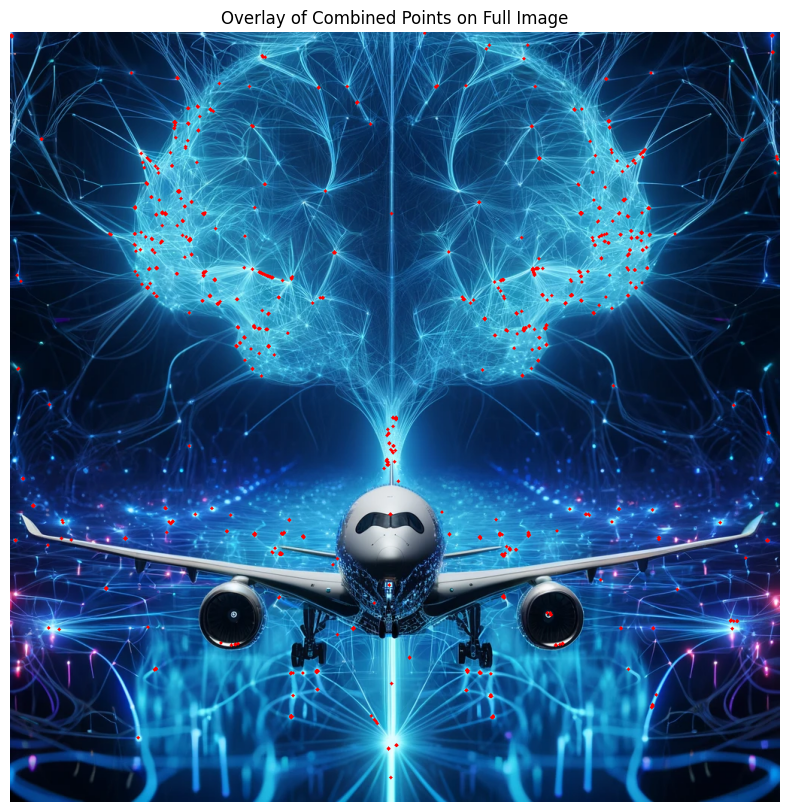

In [16]:
processor.process_image()
processor.overlay_points_on_image()

In [17]:
combined_points = processor.get_combined_points()



combined_points.dataframe.head()

,Y,X
0,161,174
1,289,173
2,313,311
3,315,322
4,330,362


In [43]:
import random
from PIL import Image, ImageDraw

# Load the provided background image
background_image_path = './network.webp'
background_image = Image.open(background_image_path)

# Update the drawing functions to use the specified colors
class Star:
    def __init__(self, radius, color, position):
        self.radius = radius
        self.color = color
        self.position = position

    def draw(self, image):
        draw = ImageDraw.Draw(image)
        left_up_point = (self.position[0] - self.radius, self.position[1] - self.radius)
        right_down_point = (self.position[0] + self.radius, self.position[1] + self.radius)
        draw.ellipse([left_up_point, right_down_point], fill=self.color + (255,))

    @classmethod
    def from_dict(cls, data):
        return cls(
            radius=data.get('radius', random.randint(5, 10)),
            color=data.get('color', (0, 0, 255)),  # Blue stars
            position=data.get('position', (random.randint(0, 1200), random.randint(0, 1200)))
        )


class Corona:
    def __init__(self, star_radius, outer_radius, color, position):
        self.inner_radius = star_radius
        self.outer_radius = outer_radius
        self.color = color
        self.position = position

    def draw(self, image):
        draw = ImageDraw.Draw(image)
        for i in range(self.inner_radius, self.outer_radius):
            alpha = int(255 * (1 - (i - self.inner_radius) / (self.outer_radius - self.inner_radius)) ** 2)
            left_up_point = (self.position[0] - i, self.position[1] - i)
            right_down_point = (self.position[0] + i, self.position[1] + i)
            draw.ellipse([left_up_point, right_down_point], outline=self.color + (alpha,), width=1)

    @classmethod
    def from_dict(cls, data):
        return cls(
            star_radius=data['star_radius'],
            outer_radius=data.get('outer_radius', data['star_radius'] + random.randint(1, 10)),
            color=data.get('color', (255, 0, 0)),  # Red coronas
            position=data['position']
        )


class StarSpike:
    def __init__(self, length, width, color, position, orientation):
        self.length = length
        self.width = width
        self.color = color
        self.position = position
        self.orientation = orientation

    def draw(self, image):
        draw = ImageDraw.Draw(image)
        if self.orientation == 'horizontal':
            left_up_point = (self.position[0] - self.length, self.position[1] - self.width // 2)
            right_down_point = (self.position[0] + self.length, self.position[1] + self.width // 2)
        else:
            left_up_point = (self.position[0] - self.width // 2, self.position[1] - self.length)
            right_down_point = (self.position[0] + self.width // 2, self.position[1] + self.length)
        draw.ellipse([left_up_point, right_down_point], fill=self.color + (255,))

    @classmethod
    def from_dict(cls, data):
        return cls(
            length=data['length'],
            width=data['width'],
            color=data.get('color', (0, 255, 0)),  # Green rays
            position=data['position'],
            orientation=data['orientation']
        )


class StarSpikeCorona:
    def __init__(self, inner_length, outer_length, width, color, position, orientation):
        self.inner_length = inner_length
        self.outer_length = outer_length
        self.width = width
        self.color = color
        self.position = position
        self.orientation = orientation

    def draw(self, image):
        draw = ImageDraw.Draw(image)
        for i in range(self.inner_length, self.outer_length):
            alpha = int(255 * (1 - (i - self.inner_length) / (self.outer_length - self.inner_length)) ** 2)
            if self.orientation == 'horizontal':
                left_up_point = (self.position[0] - i, self.position[1] - self.width // 2)
                right_down_point = (self.position[0] + i, self.position[1] + self.width // 2)
            else:
                left_up_point = (self.position[0] - self.width // 2, self.position[1] - i)
                right_down_point = (self.position[0] + self.width // 2, self.position[1] + i)
            draw.ellipse([left_up_point, right_down_point], outline=self.color + (alpha,), width=1)

    @classmethod
    def from_dict(cls, data):
        return cls(
            inner_length=data['inner_length'],
            outer_length=data['outer_length'],
            width=data['width'],
            color=data.get('color', (255, 255, 0)),  # Yellow ray coronas
            position=data['position'],
            orientation=data['orientation']
        )


class StarrySkyAnimationWithVariedRaysAndTiming:
    min_radius = 5
    max_radius = 10
    min_outer_radius_offset = 1
    max_outer_radius_offset = 10
    min_twinkle_interval = 10
    max_twinkle_interval = 30
    min_spike_length = 5
    max_spike_length = 10
    spike_width = 3

    def __init__(self, size=(1200, 1200), background_color=(0, 0, 0), star_positions=None, frame_count=60):
        if background_image_path:
            self.background_image = Image.open(background_image_path)
            if size == (1200, 1200):  # Default size, adjust to image size if not explicitly specified
                self.size = self.background_image.size
            else:
                self.size = size
                self.background_image = self.background_image.resize(self.size)
        else:
            self.size = size
            self.background_image = Image.new("RGB", self.size, background_color)
        self.background_color = background_color
        self.star_count = len(star_positions) if star_positions is not None else 20
        self.frame_count = frame_count
        self.image_sequence = []
        self.stars = [
            Star.from_dict({
                'radius': random.randint(self.min_radius, self.max_radius),
                'position': (position[1], position[0])  # Correcting the coordinate order
            }) for position in (star_positions if star_positions is not None else [(random.randint(0, size[0]), random.randint(0, size[1])) for _ in range(self.star_count)])
        ]
        self.coronas = [
            Corona.from_dict({
                'star_radius': star.radius,
                'position': star.position
            }) for star in self.stars
        ]
        self.twinkle_intervals = [random.randint(self.min_twinkle_interval, self.max_twinkle_interval) for _ in range(self.star_count)]

    def get_adjusted_length(self, spike_length, frame):
        if frame % 5 == 0 or frame % 5 == 4:
            return int(spike_length * 1/3)
        elif frame % 5 == 1 or frame % 5 == 3:
            return int(spike_length * 2/3)
        else:
            return int(spike_length)

    def create_spikes(self, image, star, spike_length, num_rays, frame):
        orientations = ['horizontal', 'vertical']
        colors = [(0, 255, 0), (0, 255, 0)]
        
        adjusted_length = self.get_adjusted_length(spike_length, frame)
        
        for _ in range(num_rays // 2):
            for orientation, color in zip(orientations, colors):
                spike = StarSpike.from_dict({
                    'length': adjusted_length * self.min_spike_length,
                    'width': self.spike_width,
                    'position': star.position,
                    'orientation': orientation
                })
                spike.draw(image)
                spike_corona = StarSpikeCorona.from_dict({
                    'inner_length': adjusted_length * self.min_spike_length,
                    'outer_length': adjusted_length * self.min_spike_length + 10,
                    'width': self.spike_width + 1,
                    'color': (255, 255, 0),
                    'position': star.position,
                    'orientation': orientation
                })
                spike_corona.draw(image)
            orientations = orientations[::-1]  # Switch between horizontal and vertical

    def create_frame(self, frame_index):
        image = self.background_image.copy()
        for star, corona in zip(self.stars, self.coronas):
            star.draw(image)
            corona.draw(image)
        
        for star_idx, (star, interval) in enumerate(zip(self.stars, self.twinkle_intervals)):
            star_frame_index = frame_index - (star_idx * 5)
            if 0 <= star_frame_index < 5:  # Only animate if within the 5-frame window
                spike_length = (frame_index % 20) + 1
                num_rays = random.choice([4, 8])
                self.create_spikes(image, star, spike_length, num_rays, star_frame_index)
        return image

    def generate_animation(self):
        for frame_index in range(self.frame_count):
            frame = self.create_frame(frame_index)
            self.image_sequence.append(frame)
        return self.image_sequence

    def save_gif(self, filename):
        self.image_sequence[0].save(
            filename,
            save_all=True,
            append_images=self.image_sequence[1:],
            duration=100,
            loop=0,
            optimize=False
        )


In [44]:
# Example usage
combined_points = processor.get_combined_points()  # Assuming you already have the combined_points named tuple
combined_points.coordinates

array([[161, 174],
       [289, 173],
       [313, 311],
       ...,
       [948, 514],
       [952, 503],
       [953, 503]], dtype=int64)

In [45]:
animation = StarrySkyAnimationWithVariedRaysAndTiming(star_positions=combined_points.coordinates, size=(1200, 1200), frame_count=60)
animation.generate_animation()
animation.save_gif('starry_sky.gif')

In [53]:
class StarrySkyAnimationWithVariedRaysAndTiming:
    min_radius = 1
    max_radius = 1
    min_outer_radius_offset = 0
    max_outer_radius_offset = 3
    min_twinkle_interval = 10
    max_twinkle_interval = 30
    min_spike_length = 6
    max_spike_length = 10
    spike_width = 1

    def __init__(self, background_image_path=None, size=(1200, 1200), background_color=(0, 0, 0), star_positions=None, frame_count=60, star_color=(0, 0, 255), corona_color=(255, 0, 0), spike_color=(0, 255, 0), spike_corona_color=(255, 255, 0)):
        if background_image_path:
            self.background_image = Image.open(background_image_path)
            if size == (1200, 1200):  # Default size, adjust to image size if not explicitly specified
                self.size = self.background_image.size
            else:
                self.size = size
                self.background_image = self.background_image.resize(self.size)
        else:
            self.size = size
            self.background_image = Image.new("RGB", self.size, background_color)

        self.star_positions = star_positions if star_positions is not None else [(random.randint(0, self.size[0]), random.randint(0, self.size[1])) for _ in range(20)]
        self.star_count = len(self.star_positions)
        self.frame_count = frame_count
        self.image_sequence = []
        self.star_color = star_color
        self.corona_color = corona_color
        self.spike_color = spike_color
        self.spike_corona_color = spike_corona_color
        self.stars = [
            Star.from_dict({
                'radius': random.randint(self.min_radius, self.max_radius),
                'color': self.star_color,
                'position': (position[1], position[0])  # Correcting the coordinate order
            }) for position in self.star_positions
        ]
        self.coronas = [
            Corona.from_dict({
                'star_radius': star.radius,
                'outer_radius': star.radius + random.randint(self.min_outer_radius_offset, self.max_outer_radius_offset),
                'color': self.corona_color,
                'position': star.position
            }) for star in self.stars
        ]
        self.twinkle_intervals = [random.randint(self.min_twinkle_interval, self.max_twinkle_interval) for _ in range(self.star_count)]

    def get_adjusted_length(self, spike_length, frame):
        if frame % 5 == 0 or frame % 5 == 4:
            return int(spike_length * 1/3)
        elif frame % 5 == 1 or frame % 5 == 3:
            return int(spike_length * 2/3)
        else:
            return int(spike_length)

    def create_spikes(self, image, star, spike_length, num_rays, frame):
        orientations = ['horizontal', 'vertical']
        adjusted_length = self.get_adjusted_length(spike_length, frame)
        
        for _ in range(num_rays // 2):
            for orientation in orientations:
                spike = StarSpike.from_dict({
                    'length': adjusted_length * self.min_spike_length,
                    'width': self.spike_width,
                    'color': self.spike_color,
                    'position': star.position,
                    'orientation': orientation
                })
                spike.draw(image)
                spike_corona = StarSpikeCorona.from_dict({
                    'inner_length': adjusted_length * self.min_spike_length,
                    'outer_length': adjusted_length * self.min_spike_length + 10,
                    'width': self.spike_width + 1,
                    'color': self.spike_corona_color,
                    'position': star.position,
                    'orientation': orientation
                })
                spike_corona.draw(image)
            orientations = orientations[::-1]  # Switch between horizontal and vertical

    def create_frame(self, frame_index):
        image = self.background_image.copy()
        for star, corona in zip(self.stars, self.coronas):
            star.draw(image)
            corona.draw(image)
        
        for star_idx, (star, interval) in enumerate(zip(self.stars, self.twinkle_intervals)):
            star_frame_index = frame_index - (star_idx * 5)
            if 0 <= star_frame_index < 5:  # Only animate if within the 5-frame window
                spike_length = (frame_index % 20) + 1
                num_rays = random.choice([4, 8])
                self.create_spikes(image, star, spike_length, num_rays, star_frame_index)
        return image

    def generate_animation(self):
        for frame_index in range(self.frame_count):
            frame = self.create_frame(frame_index)
            self.image_sequence.append(frame)
        return self.image_sequence

    def save_gif(self, filename):
        self.image_sequence[0].save(
            filename,
            save_all=True,
            append_images=self.image_sequence[1:],
            duration=100,
            loop=0,
            optimize=False
        )

In [54]:
# Assuming combined_points is the named tuple from the processor
combined_points = processor.get_combined_points()
star_positions = combined_points.coordinates

In [55]:
color_palette = {
    'Red': (255, 0, 0),
    'Green': (0, 255, 0),
    'Blue': (0, 0, 255),
    'Yellow': (255, 255, 0),
    'Cyan': (0, 255, 255),
    'Magenta': (255, 0, 255),
    'Orange': (255, 165, 0),
    'Purple': (128, 0, 128),
    'Pink': (255, 192, 203),
    'Lime': (0, 255, 0),
    'Teal': (0, 128, 128),
    'Lavender': (230, 230, 250),
    'Brown': (165, 42, 42),
    'Beige': (245, 245, 220),
    'Maroon': (128, 0, 0),
    'Mint': (189, 252, 201),
    'Olive': (128, 128, 0),
    'Coral': (255, 127, 80),
    'Navy': (0, 0, 128),
    'Grey': (128, 128, 128),
    'Silver': (192, 192, 192),
    'Gold': (255, 215, 0),
    'Peach': (255, 218, 185),
    'Plum': (221, 160, 221),
    'Ivory': (255, 255, 240),
    'Turquoise': (64, 224, 208),
    'Violet': (238, 130, 238),
    'Aqua': (0, 255, 255),
    'SkyBlue': (135, 206, 235),
    'Salmon': (250, 128, 114),
    'Khaki': (240, 230, 140),
    'Crimson': (220, 20, 60),
    'Orchid': (218, 112, 214),
    'Tomato': (255, 99, 71),
    'Honeydew': (240, 255, 240),
    'Chartreuse': (127, 255, 0),
    'SlateBlue': (106, 90, 205),
    'Tan': (210, 180, 140),
    'RosyBrown': (188, 143, 143),
    'MediumOrchid': (186, 85, 211),
    'MediumPurple': (147, 112, 219),
    'MistyRose': (255, 228, 225),
    'LightCoral': (240, 128, 128),
    'SeaGreen': (46, 139, 87),
    'SpringGreen': (0, 255, 127),
    'Wheat': (245, 222, 179),
    'Sienna': (160, 82, 45),
    'LightBlue': (173, 216, 230),
    'LightGreen': (144, 238, 144),
    'White': (255, 255, 255),
    'Black': (0, 0, 0),
    'ForestGreen': (34, 139, 34),
    'RoyalBlue': (65, 105, 225),
    'DeepPink': (255, 20, 147),
    'Indigo': (75, 0, 130),
    'HotPink': (255, 105, 180),
    'DarkOrange': (255, 140, 0),
    'LightSalmon': (255, 160, 122),
    'MediumSeaGreen': (60, 179, 113),
    'DarkSlateBlue': (72, 61, 139),
    'MediumSpringGreen': (0, 250, 154),
    'LemonChiffon': (255, 250, 205),
    'MediumVioletRed': (199, 21, 133),
    'PaleGreen': (152, 251, 152),
    'PaleTurquoise': (175, 238, 238),
    'SlateGray': (112, 128, 144),
    'LightSkyBlue': (135, 206, 250),
    'MediumSlateBlue': (123, 104, 238),
    'LightSteelBlue': (176, 196, 222),
    'PaleVioletRed': (219, 112, 147),
    'Thistle': (216, 191, 216),
    'Azure': (240, 255, 255),
    'LightGoldenrodYellow': (250, 250, 210),
    'PapayaWhip': (255, 239, 213),
    'AntiqueWhite': (250, 235, 215),
    'Moccasin': (255, 228, 181),
    'Bisque': (255, 228, 196),
    'SlateGrey': (112, 128, 144),
    'DarkTurquoise': (0, 206, 209),
    'PaleGoldenrod': (238, 232, 170),
    'LightSlateGray': (119, 136, 153),
    'GhostWhite': (248, 248, 255),
    'LavenderBlush': (255, 240, 245),
    'Seashell': (255, 245, 238),
    'Cornsilk': (255, 248, 220),
    'BlanchedAlmond': (255, 235, 205),
    'NavajoWhite': (255, 222, 173),
    'MintCream': (245, 255, 250),
    'FloralWhite': (255, 250, 240),
    'AliceBlue': (240, 248, 255),
    'OldLace': (253, 245, 230),
    'DarkKhaki': (189, 183, 107),
    'LightSeaGreen': (32, 178, 170),
    'MediumAquamarine': (102, 205, 170),
    'DimGray': (105, 105, 105),
    'PowderBlue': (176, 224, 230),
    'FireBrick': (178, 34, 34),
    'DarkGoldenrod': (184, 134, 11)
}

# Example of how to use the colors:
print(color_palette['Red'])  # Output: (255, 0, 0)
print(color_palette['SkyBlue'])  # Output: (135, 206, 235)


(255, 0, 0)
(135, 206, 235)


In [56]:
animation = StarrySkyAnimationWithVariedRaysAndTiming(
    background_image_path='./network.webp',  # Path to the background image
    #size=(1200, 1200),  # Specified size
    star_positions=star_positions, 
    frame_count=60,
    star_color=color_palette['White'],  # White  stars
    corona_color=color_palette['White'],  # White coronas
    spike_color=color_palette['White'],  # White rays
    spike_corona_color=color_palette['White']  # White ray coronas
)
animation.generate_animation()
animation.save_gif('starry_sky.gif')

In [20]:
# Example usage with specified star positions
star_positions = [(100, 100), (200, 200), (300, 300), (400, 400), (500, 500)]
animation = StarrySkyAnimationWithVariedRaysAndTiming(star_count=5, frame_count=60, star_positions=star_positions)
animation.generate_animation()
animation.save_gif('twinkle_stars_with_specified_background.gif')

TypeError: StarrySkyAnimationWithVariedRaysAndTiming.__init__() got an unexpected keyword argument 'star_count'